# Source: https://juanitorduz.github.io/synthetic_control_pymc/

In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/home/jbris/.cache/pypoetry/virtualenvs/synthetic-control-pymc-DMxhroEE-py3.10/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
data_path = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv"

raw_data_df = pd.read_csv(data_path)

raw_data_df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


In [3]:
# select relevant columns
df = raw_data_df.copy().drop(columns=["lnincome", "beer", "age15to24"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            1209 non-null   int64  
 1   year             1209 non-null   int64  
 2   cigsale          1209 non-null   float64
 3   retprice         1209 non-null   float64
 4   california       1209 non-null   bool   
 5   after_treatment  1209 non-null   bool   
dtypes: bool(2), float64(2), int64(2)
memory usage: 40.3 KB


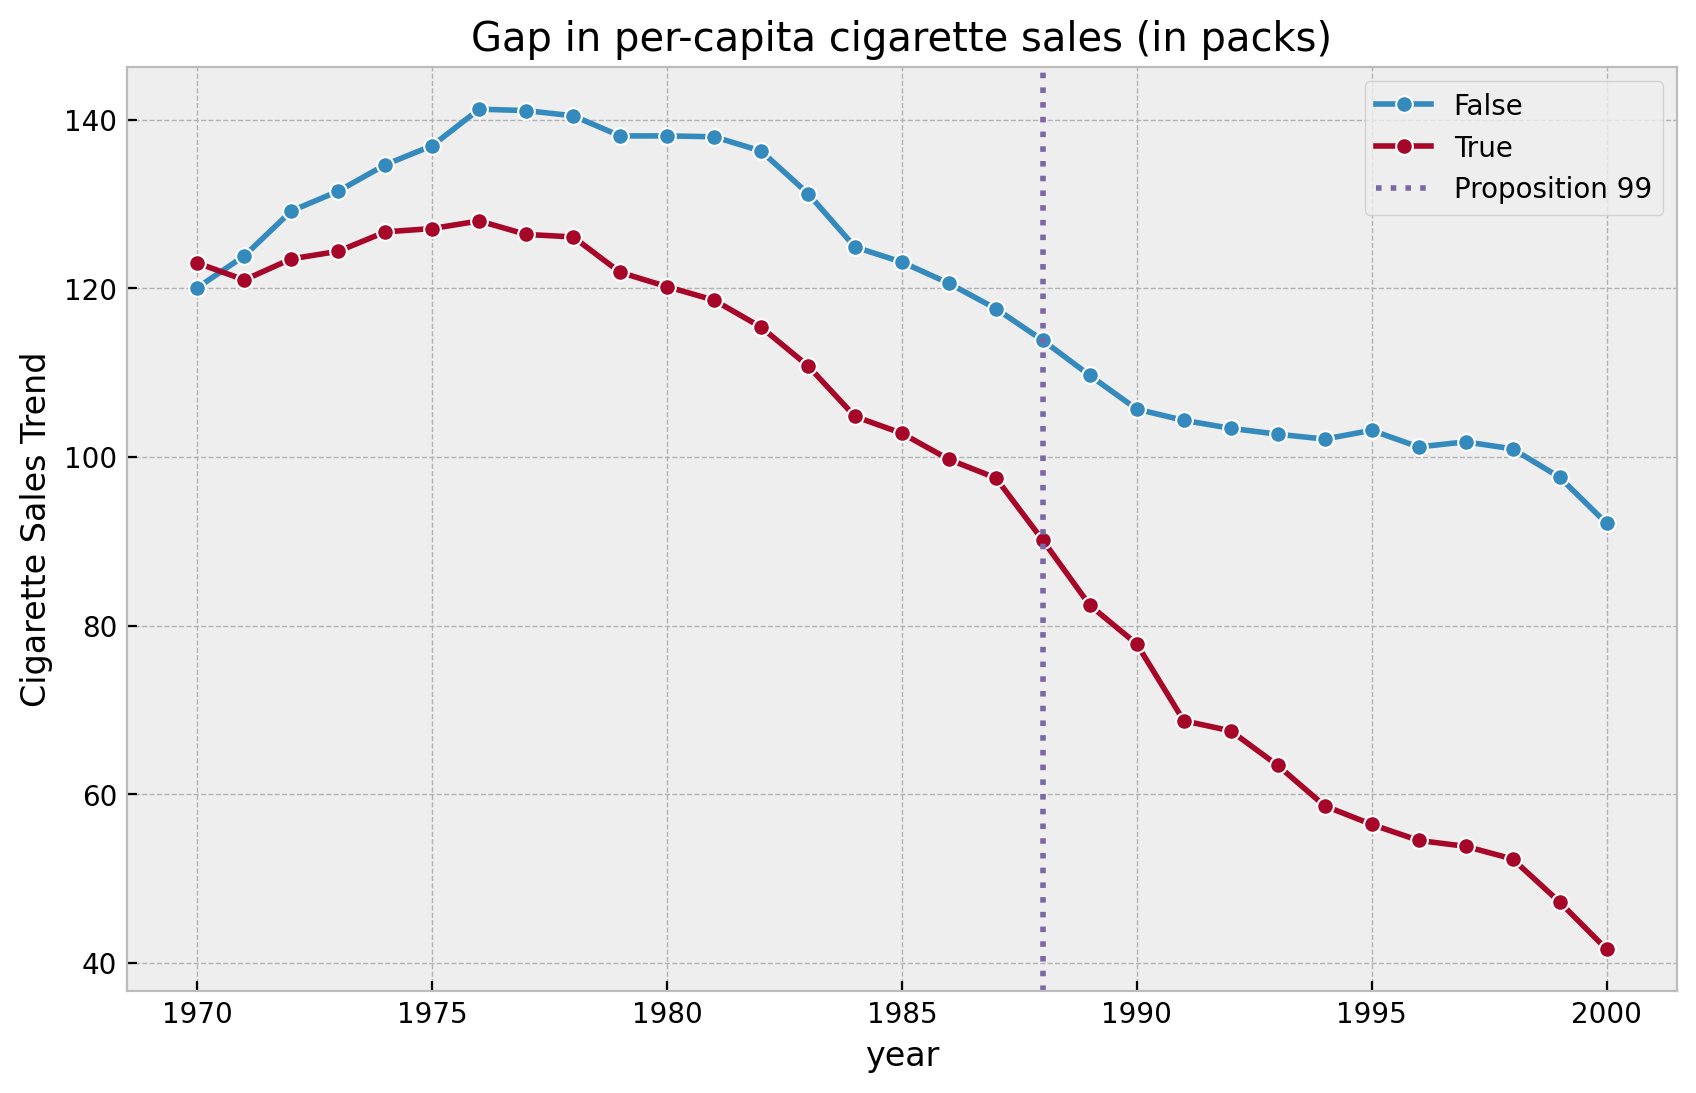

In [4]:
fig, ax = plt.subplots()

(
    df.groupby(["year", "california"], as_index=False)
    .agg({"cigsale": np.mean})
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="cigsale",
        hue="california",
        marker="o",
        ax=ax,
    )
)
ax.axvline(
    x=1988,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
ax.legend(loc="upper right")
ax.set(
    title="Gap in per-capita cigarette sales (in packs)",
    ylabel="Cigarette Sales Trend"
);

In [7]:
features = ["cigsale", "retprice"]

pre_df = (
    df
    .query("~ after_treatment")
    .pivot(index='state', columns="year", values=features)
    .T
)

post_df = (
    df
    .query("after_treatment")
    .pivot(index='state', columns="year", values=features)
    .T
)

idx = 3

y_pre = pre_df[idx].to_numpy()
x_pre = pre_df.drop(columns=idx).to_numpy()
pre_years = pre_df.reset_index(inplace=False).year.unique()
n_pre = pre_years.size

y_post = post_df[idx].to_numpy()
x_post = post_df.drop(columns=idx).to_numpy()
post_years = post_df.reset_index(inplace=False).year.unique()
n_post = post_years.size

k = pre_df.shape[1] - 1

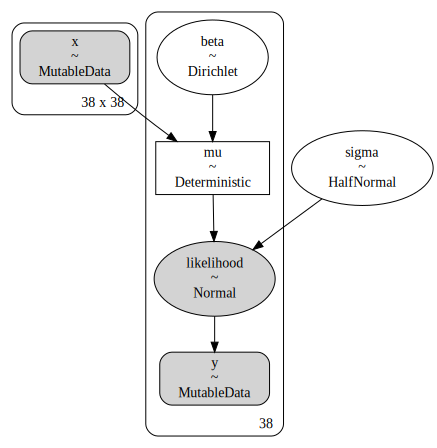

In [8]:
with pm.Model() as model:
    x = pm.MutableData(name="x", value=x_pre)
    y = pm.MutableData(name="y", value=y_pre)
    beta = pm.Dirichlet(name="beta", a=(1 / k) * np.ones(k))
    sigma = pm.HalfNormal(name="sigma", sigma=5)
    mu = pm.Deterministic(name="mu", var=pm.math.dot(x, beta))
    likelihood = pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(model)

/home/jbris/.cache/pypoetry/virtualenvs/synthetic-control-pymc-DMxhroEE-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:02.265138
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:04<?, ?it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:04<00:14, 328.10it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:05<00:16, 280.71it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:05<00:18, 259.37it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:05<00:15, 295.60it/s]


Runni

Sampling time =  0:00:24.397197
Transforming variables...
Transformation time =  0:00:00.361875
Computing Log Likelihood...
Log Likelihood time =  0:00:00.536108


Sampling: [likelihood]


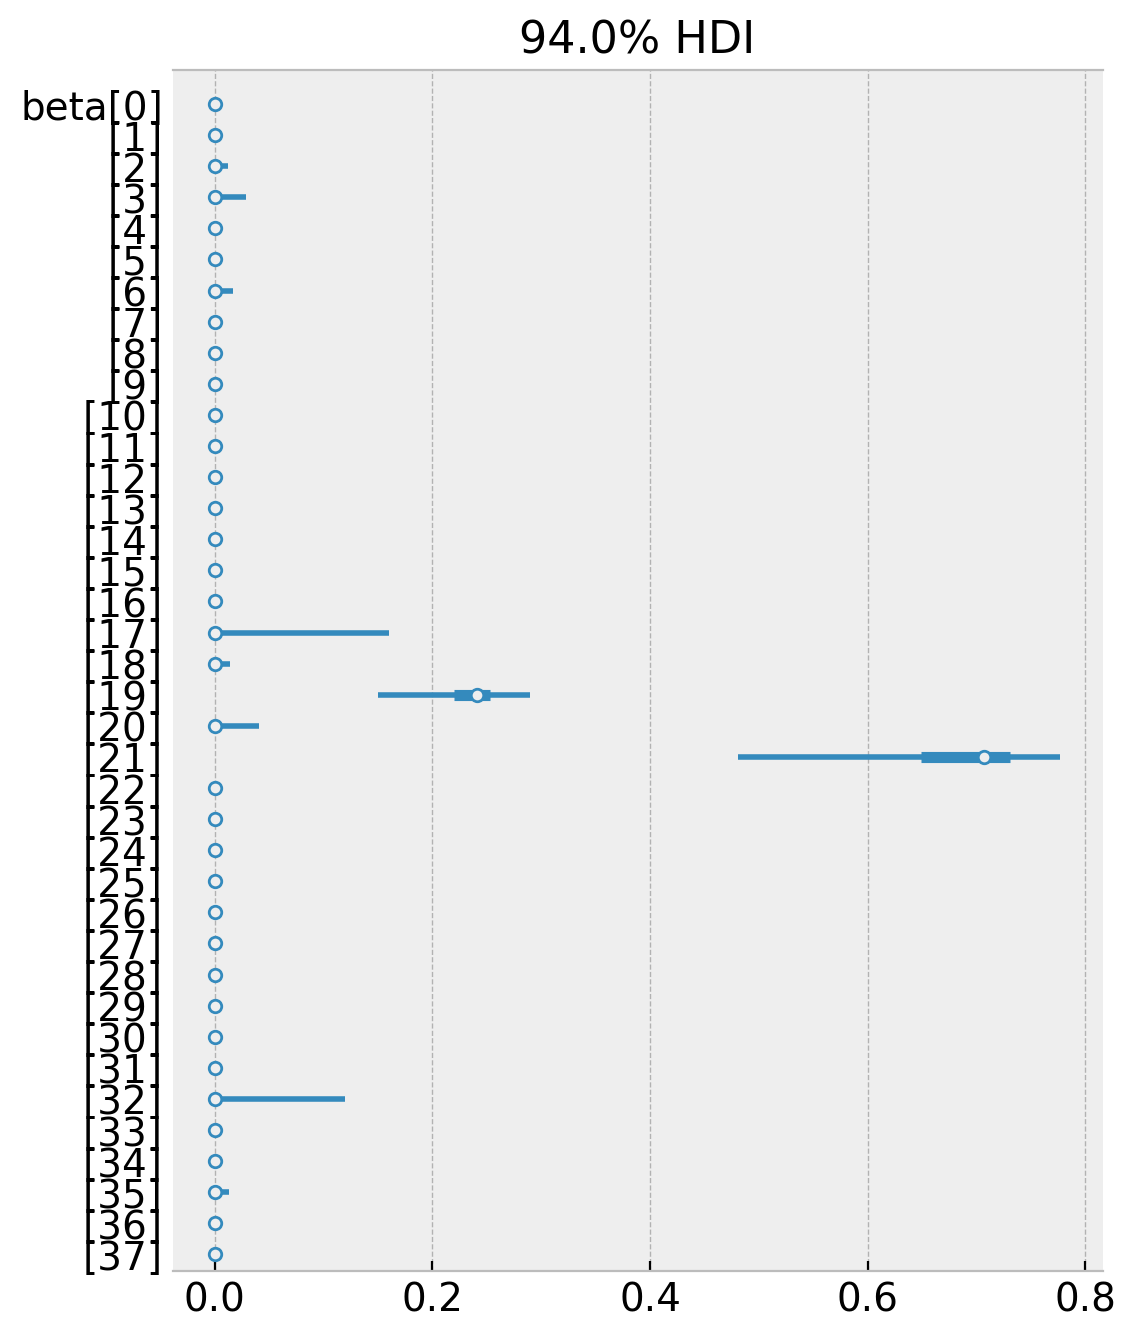

In [9]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

az.plot_forest(data=idata, combined=True, var_names=["beta"]);

In [10]:
np.unique(
    idata
    .posterior["beta"]
    .stack(samples=("chain", "draw"))
    .sum(axis=0)
    .to_numpy()
    - 1
)

array([-5.55111512e-16, -4.44089210e-16, -3.33066907e-16, -2.22044605e-16,
       -1.11022302e-16,  0.00000000e+00,  2.22044605e-16,  4.44089210e-16])

Sampling: [likelihood]


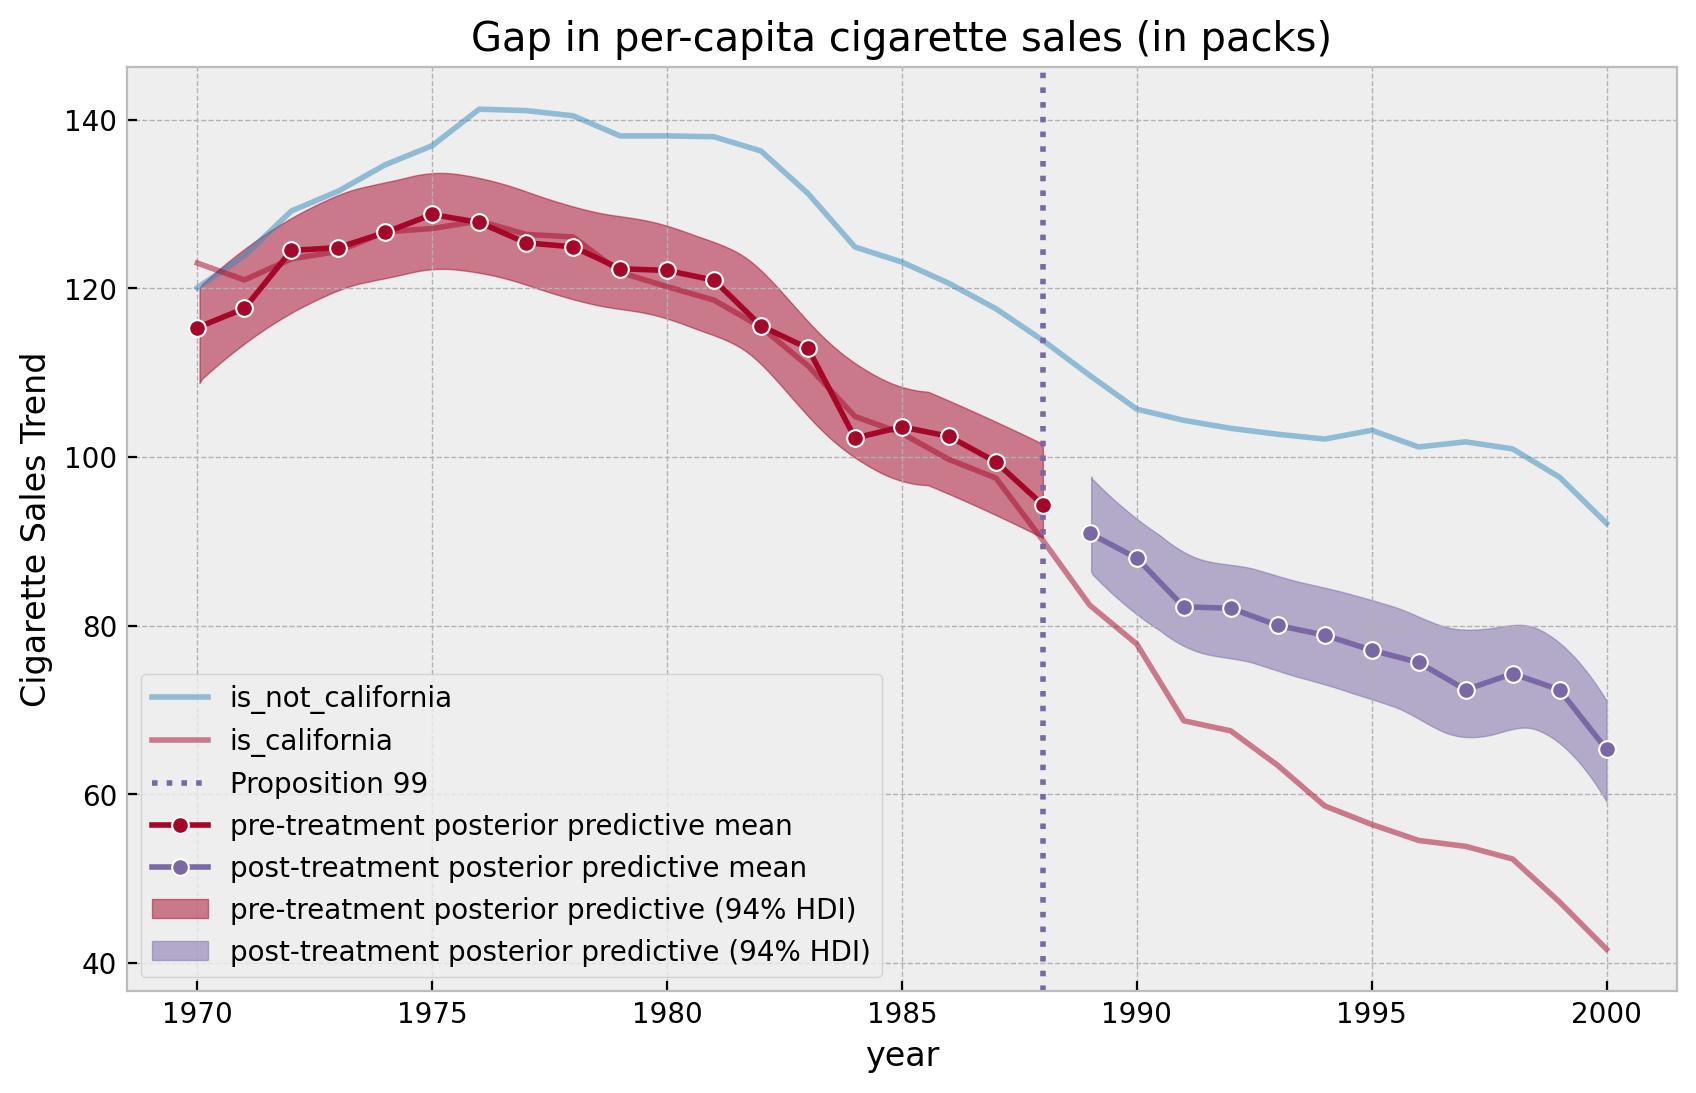

In [11]:
with model:
    pm.set_data(new_data={"x": x_post, "y": y_post})
    posterior_predictive_post = pm.sample_posterior_predictive(
        trace=idata, var_names=["likelihood"]
    )

pre_posterior_mean = (
    posterior_predictive_pre.posterior_predictive["likelihood"][:, :, :n_pre]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)

post_posterior_mean = (
    posterior_predictive_post.posterior_predictive["likelihood"][:, :, :n_post]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)


fig, ax = plt.subplots()

(
    df.groupby(["year", "california"], as_index=False)
    .agg({"cigsale": np.mean})
    .assign(
        california=lambda x: x.california.map(
            {True: "is_california", False: "is_not_california"}
        )
    )
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="cigsale",
        hue="california",
        alpha=0.5,
        ax=ax,
    )
)
ax.axvline(
    x=1988,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
sns.lineplot(
    x=pre_years,
    y=pre_posterior_mean,
    color="C1",
    marker="o",
    label="pre-treatment posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=post_years,
    y=post_posterior_mean,
    color="C2",
    marker="o",
    label="post-treatment posterior predictive mean",
    ax=ax,
)
az.plot_hdi(
    x=pre_years,
    y=posterior_predictive_pre.posterior_predictive["likelihood"][:, :, :n_pre],
    smooth=True,
    color="C1",
    fill_kwargs={"label": "pre-treatment posterior predictive (94% HDI)"},
    ax=ax,
)
az.plot_hdi(
    x=post_years,
    y=posterior_predictive_post.posterior_predictive["likelihood"][:, :, :n_post],
    smooth=True,
    color="C2",
    fill_kwargs={"label": "post-treatment posterior predictive (94% HDI)"},
    ax=ax,
)
ax.legend(loc="lower left")
ax.set(
    title="Gap in per-capita cigarette sales (in packs)", ylabel="Cigarette Sales Trend"
);

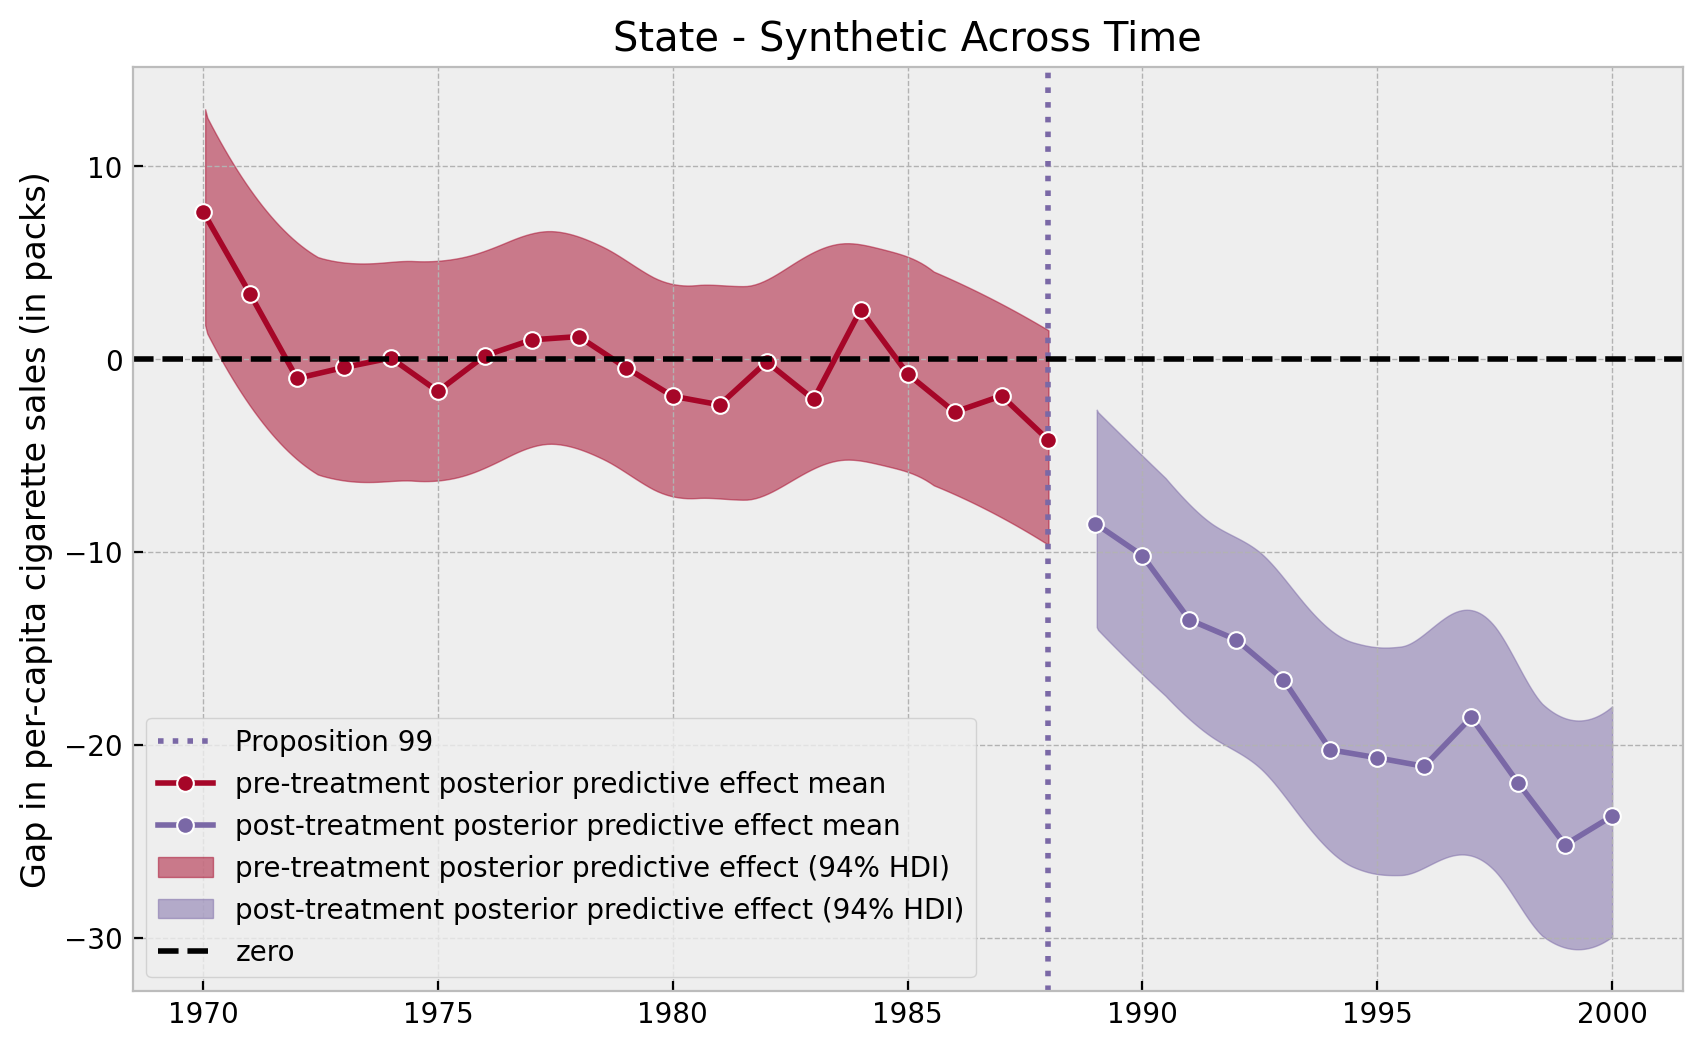

In [12]:
fig, ax = plt.subplots()

ax.axvline(
    x=1988,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
sns.lineplot(
    x=pre_years,
    y=y_pre[:n_pre] - pre_posterior_mean,
    color="C1",
    marker="o",
    label="pre-treatment posterior predictive effect mean",
    ax=ax,
)
sns.lineplot(
    x=post_years,
    y=y_post[:n_post] - post_posterior_mean,
    color="C2",
    marker="o",
    label="post-treatment posterior predictive effect mean",
    ax=ax,
)
az.plot_hdi(
    x=pre_years,
    y=y_pre[:n_pre]
    - posterior_predictive_pre.posterior_predictive["likelihood"][:, :, :n_pre],
    smooth=True,
    color="C1",
    fill_kwargs={"label": "pre-treatment posterior predictive effect (94% HDI)"},
    ax=ax,
)
az.plot_hdi(
    x=post_years,
    y=y_post[:n_post]
    - posterior_predictive_post.posterior_predictive["likelihood"][:, :, :n_post],
    smooth=True,
    color="C2",
    fill_kwargs={"label": "post-treatment posterior predictive effect (94% HDI)"},
    ax=ax,
)
ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="lower left")
ax.set(
    title="State - Synthetic Across Time",
    ylabel="Gap in per-capita cigarette sales (in packs)",
);



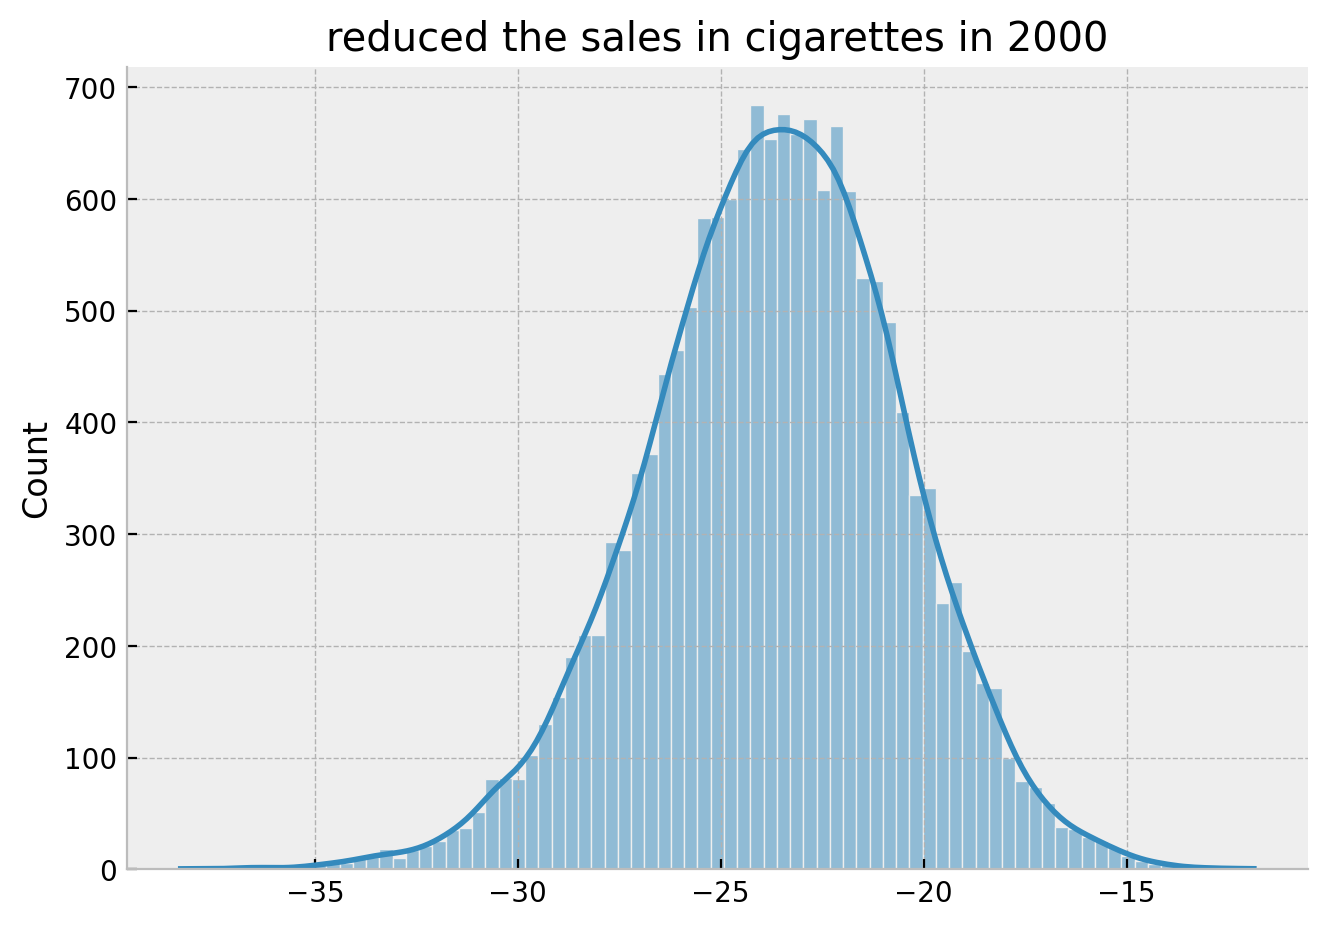

In [13]:
g = (
    (
        y_post[:n_post]
        - posterior_predictive_post.posterior_predictive["likelihood"][:, :, :n_post]
    )[:, :, -1]
    .stack(samples=("chain", "draw"))
    .pipe((sns.displot, "data"), kde=True, height=4.5, aspect=1.5)
)
g.set(title="reduced the sales in cigarettes in 2000");

# Making Inference

In [14]:
def run_synthetic_control(
    pre_df: pd.DataFrame, post_df: pd.DataFrame, idx: int
) -> tuple:
    # prepare data
    y_pre = pre_df[idx].to_numpy()
    x_pre = pre_df.drop(columns=idx).to_numpy()
    pre_years = pre_df.reset_index(inplace=False).year.unique()
    n_pre = pre_years.size

    y_post = post_df[idx].to_numpy()
    x_post = post_df.drop(columns=idx).to_numpy()
    post_years = post_df.reset_index(inplace=False).year.unique()
    n_post = post_years.size

    k = pre_df.shape[1] - 1

    # specify the model
    with pm.Model() as model:
        x = pm.MutableData(name="x", value=x_pre)
        y = pm.MutableData(name="y", value=y_pre)

        beta = pm.Dirichlet(name="beta", a=(1 / k) * np.ones(k))
        sigma = pm.HalfNormal(name="sigma", sigma=5)
        mu = pm.Deterministic(name="mu", var=pm.math.dot(x, beta))
        likelihood = pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=y)

        # fit the model
        idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
        posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)
        # post-treatment predictive distribution
        pm.set_data(new_data={"x": x_post, "y": y_post})
        posterior_predictive_post = pm.sample_posterior_predictive(
            trace=idata, var_names=["likelihood"]
        )

        # compute errors
        error_pre = (
            y_pre[:n_pre]
            - posterior_predictive_pre.posterior_predictive["likelihood"][:, :, :n_pre]
        )
        error_post = (
            y_post[:n_post]
            - posterior_predictive_post.posterior_predictive["likelihood"][
                :, :, :n_post
            ]
        )

    return error_pre, error_post

In [15]:
results = {
    idx: run_synthetic_control(pre_df=pre_df, post_df=post_df, idx=idx)
    for idx in df["state"].unique()
}

Compiling...
Compilation time =  0:00:02.088722
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:04<?, ?it/s]

Running chain 1:   0%|                                                  | 0/5000 [00:04<?, ?it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:05<00:17, 270.91it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:05<00:20, 232.30it/s]


Running chain 1:  10%|███▉                                   | 500/5000 [00:06<00:16, 280.06it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:06<00:17, 257.56it/s]


Runni

Sampling time =  0:00:27.592628
Transforming variables...
Transformation time =  0:00:00.080762
Computing Log Likelihood...
Log Likelihood time =  0:00:00.193951


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.953605
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:03<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:03<?, ?it/s]


Running chain 0:   5%|█▉                                     | 250/5000 [00:04<00:13, 358.71it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:04<00:18, 256.86it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:05<00:14, 308.48it/s]


Running chain 3:  10%|███▉                                   | 500/5000 [00:05<00:15, 299.83it/s]

Runni

Sampling time =  0:00:21.584591
Transforming variables...
Transformation time =  0:00:00.079030
Computing Log Likelihood...
Log Likelihood time =  0:00:00.352061


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.121766
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:02<00:07, 674.72it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:12, 387.73it/s]


Running chain 3:  10%|███▉                                   | 500/5000 [00:03<00:07, 620.04it/s]

Runni

Sampling time =  0:00:12.542978
Transforming variables...
Transformation time =  0:00:00.059252
Computing Log Likelihood...
Log Likelihood time =  0:00:00.137922


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.256569
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 546.10it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:09, 504.42it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 560.11it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:08, 539.84it/s]


Runni

Sampling time =  0:00:13.395170
Transforming variables...
Transformation time =  0:00:00.049356
Computing Log Likelihood...
Log Likelihood time =  0:00:00.131932


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.144954
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:07, 643.77it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 582.48it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:08, 578.59it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:07, 601.18it/s]


Runni

Sampling time =  0:00:11.544383
Transforming variables...
Transformation time =  0:00:00.049148
Computing Log Likelihood...
Log Likelihood time =  0:00:00.120511


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.320947
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:02<00:07, 647.72it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:02<00:09, 482.94it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:06, 647.41it/s]


Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:07, 578.76it/s]

Runni

Sampling time =  0:00:11.368553
Transforming variables...
Transformation time =  0:00:00.049092
Computing Log Likelihood...
Log Likelihood time =  0:00:00.127739


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.578885
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 562.26it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:08, 558.58it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:08, 556.58it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 526.70it/s]


Runni

Sampling time =  0:00:13.604247
Transforming variables...
Transformation time =  0:00:00.045216
Computing Log Likelihood...
Log Likelihood time =  0:00:00.121661


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.324552
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:02<00:07, 637.72it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:02<00:08, 584.23it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:06, 647.40it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:07, 603.00it/s]


Runni

Sampling time =  0:00:12.916629
Transforming variables...
Transformation time =  0:00:00.049264
Computing Log Likelihood...
Log Likelihood time =  0:00:00.134221


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.176920
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:02<00:09, 519.38it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:02<00:09, 482.18it/s]

Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:09, 497.03it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:09, 496.91it/s]


Runni

Sampling time =  0:00:14.281227
Transforming variables...
Transformation time =  0:00:00.052560
Computing Log Likelihood...
Log Likelihood time =  0:00:00.135117


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.291930
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:07, 625.23it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:09, 480.98it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 507.50it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:08, 514.02it/s]


Runni

Sampling time =  0:00:13.674370
Transforming variables...
Transformation time =  0:00:00.046948
Computing Log Likelihood...
Log Likelihood time =  0:00:00.115658


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.287220
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                  | 0/5000 [00:03<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:03<?, ?it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:08, 553.71it/s]


Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:09, 500.20it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:04<00:08, 536.39it/s]


Runni

Sampling time =  0:00:13.740437
Transforming variables...
Transformation time =  0:00:00.055349
Computing Log Likelihood...
Log Likelihood time =  0:00:00.132499


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.308950
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 586.36it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:08, 579.37it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 548.94it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:08, 557.29it/s]


Runni

Sampling time =  0:00:13.739006
Transforming variables...
Transformation time =  0:00:00.059044
Computing Log Likelihood...
Log Likelihood time =  0:00:00.145952


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.568804
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 569.94it/s]


Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:09, 527.36it/s]

Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:08, 536.69it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 534.31it/s]

Runni

Sampling time =  0:00:14.448349
Transforming variables...
Transformation time =  0:00:00.052753
Computing Log Likelihood...
Log Likelihood time =  0:00:00.136167


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.586015
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 537.88it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:08, 529.16it/s]

Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:08, 525.60it/s]


Runni

Sampling time =  0:00:13.118394
Transforming variables...
Transformation time =  0:00:00.059269
Computing Log Likelihood...
Log Likelihood time =  0:00:00.139151


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.555108
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 549.12it/s]

Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:07, 601.10it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:07, 562.66it/s]

Runni

Sampling time =  0:00:13.535457
Transforming variables...
Transformation time =  0:00:00.054481
Computing Log Likelihood...
Log Likelihood time =  0:00:00.130987


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.232728
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:07, 635.80it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:08, 572.30it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:07, 596.67it/s]


Running chain 3:  10%|███▉                                   | 500/5000 [00:03<00:07, 593.50it/s]

Runni

Sampling time =  0:00:13.797014
Transforming variables...
Transformation time =  0:00:00.074867
Computing Log Likelihood...
Log Likelihood time =  0:00:00.148993


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.320303
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:08, 591.32it/s]


Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:07, 563.70it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 533.74it/s]


Runni

Sampling time =  0:00:14.439418
Transforming variables...
Transformation time =  0:00:00.089109
Computing Log Likelihood...
Log Likelihood time =  0:00:00.179878


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.557146
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:08, 585.62it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:09, 492.29it/s]


Running chain 3:  10%|███▉                                   | 500/5000 [00:03<00:08, 529.57it/s]

Runni

Sampling time =  0:00:13.959683
Transforming variables...
Transformation time =  0:00:00.065205
Computing Log Likelihood...
Log Likelihood time =  0:00:00.174252


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.545752
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:03<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:03<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:03<?, ?it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:07, 596.18it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:09, 519.38it/s]


Running chain 3:  10%|███▉                                   | 500/5000 [00:03<00:08, 561.20it/s]

Runni

Sampling time =  0:00:13.290443
Transforming variables...
Transformation time =  0:00:00.053419
Computing Log Likelihood...
Log Likelihood time =  0:00:00.146385


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.231613
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 553.19it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:08, 549.54it/s]

Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:08, 555.01it/s]


Runni

Sampling time =  0:00:14.337297
Transforming variables...
Transformation time =  0:00:00.055531
Computing Log Likelihood...
Log Likelihood time =  0:00:00.135139


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.281138
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 590.00it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:08, 589.28it/s]

Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:07, 616.42it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:07, 602.54it/s]


Runni

Sampling time =  0:00:14.272685
Transforming variables...
Transformation time =  0:00:00.054471
Computing Log Likelihood...
Log Likelihood time =  0:00:00.133487


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.559223
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 588.25it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:08, 555.01it/s]


Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:06, 672.67it/s]

Runni

Sampling time =  0:00:10.611154
Transforming variables...
Transformation time =  0:00:00.070463
Computing Log Likelihood...
Log Likelihood time =  0:00:00.174889


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.236243
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:03<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:07, 597.87it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:08, 563.06it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:07, 581.77it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:08, 529.31it/s]


Runni

Sampling time =  0:00:14.878414
Transforming variables...
Transformation time =  0:00:00.050316
Computing Log Likelihood...
Log Likelihood time =  0:00:00.126175


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.262998
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 549.94it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 531.60it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:07, 572.59it/s]


Runni

Sampling time =  0:00:13.323114
Transforming variables...
Transformation time =  0:00:00.054418
Computing Log Likelihood...
Log Likelihood time =  0:00:00.133593


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.586903
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 589.78it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 543.96it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:08, 531.78it/s]


Runni

Sampling time =  0:00:15.552755
Transforming variables...
Transformation time =  0:00:00.053678
Computing Log Likelihood...
Log Likelihood time =  0:00:00.132929


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.256556
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                  | 0/5000 [00:03<?, ?it/s]


Running chain 0:   5%|█▉                                     | 250/5000 [00:04<00:08, 590.40it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:04<00:08, 532.52it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:04<00:09, 526.55it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:04<00:08, 549.90it/s]


Runni

Sampling time =  0:00:15.233966
Transforming variables...
Transformation time =  0:00:00.064213
Computing Log Likelihood...
Log Likelihood time =  0:00:00.155668


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.257782
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 530.04it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:09, 501.98it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 551.49it/s]


Running chain 3:  10%|███▉                                   | 500/5000 [00:03<00:09, 498.53it/s]

Runni

Sampling time =  0:00:15.916871
Transforming variables...
Transformation time =  0:00:00.056187
Computing Log Likelihood...
Log Likelihood time =  0:00:00.136405


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.635827
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 527.95it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:09, 485.11it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 509.71it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:09, 497.84it/s]


Runni

Sampling time =  0:00:14.284328
Transforming variables...
Transformation time =  0:00:00.060606
Computing Log Likelihood...
Log Likelihood time =  0:00:00.155825


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.264391
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 563.59it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:08, 556.75it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 543.81it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:08, 543.06it/s]


Runni

Sampling time =  0:00:14.257153
Transforming variables...
Transformation time =  0:00:00.058893
Computing Log Likelihood...
Log Likelihood time =  0:00:00.133075


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.252720
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:07, 637.27it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 542.96it/s]


Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:07, 635.01it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:07, 579.43it/s]


Runni

Sampling time =  0:00:14.188361
Transforming variables...
Transformation time =  0:00:00.054849
Computing Log Likelihood...
Log Likelihood time =  0:00:00.149479


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.685351
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 532.82it/s]


Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:08, 531.16it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:08, 512.13it/s]


Runni

Sampling time =  0:00:14.311222
Transforming variables...
Transformation time =  0:00:00.066102
Computing Log Likelihood...
Log Likelihood time =  0:00:00.145429


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.336604
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 578.66it/s]


Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:08, 550.65it/s]

Running chain 2:  10%|███▉                                   | 500/5000 [00:03<00:09, 499.88it/s]


Runni

Sampling time =  0:00:12.247878
Transforming variables...
Transformation time =  0:00:00.058779
Computing Log Likelihood...
Log Likelihood time =  0:00:00.158009


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.667818
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:07, 595.19it/s]


Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 535.43it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:09, 526.46it/s]


Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:08, 528.73it/s]

Runni

Sampling time =  0:00:13.483461
Transforming variables...
Transformation time =  0:00:00.058164
Computing Log Likelihood...
Log Likelihood time =  0:00:00.134360


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.240310
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:06, 688.59it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:07, 620.93it/s]

Running chain 0:  10%|███▉                                   | 500/5000 [00:03<00:06, 727.56it/s]


Runni

Sampling time =  0:00:08.573980
Transforming variables...
Transformation time =  0:00:00.052873
Computing Log Likelihood...
Log Likelihood time =  0:00:00.129325


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.696050
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 589.58it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:09, 486.92it/s]

Running chain 1:  10%|███▉                                   | 500/5000 [00:03<00:07, 579.29it/s]


Runni

Sampling time =  0:00:13.869601
Transforming variables...
Transformation time =  0:00:00.051716
Computing Log Likelihood...
Log Likelihood time =  0:00:00.133886


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.260973
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:03<?, ?it/s]

Running chain 1:   0%|                                                  | 0/5000 [00:03<?, ?it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 580.06it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:09, 495.82it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:04<00:08, 534.90it/s]

Runni

Sampling time =  0:00:14.769591
Transforming variables...
Transformation time =  0:00:00.053890
Computing Log Likelihood...
Log Likelihood time =  0:00:00.172082


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.238198
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                  | 0/5000 [00:03<?, ?it/s]


Running chain 3:   0%|                                                  | 0/5000 [00:03<?, ?it/s]

Running chain 2:   0%|                                                  | 0/5000 [00:03<?, ?it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:08, 578.57it/s]

Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:08, 533.55it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:04<00:08, 548.81it/s]

Runni

Sampling time =  0:00:14.914761
Transforming variables...
Transformation time =  0:00:00.058702
Computing Log Likelihood...
Log Likelihood time =  0:00:00.150530


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.251199
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                  | 0/5000 [00:03<?, ?it/s]


Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 587.23it/s]

Running chain 2:   5%|█▉                                     | 250/5000 [00:03<00:09, 519.80it/s]


Running chain 0:  10%|███▉                                   | 500/5000 [00:04<00:08, 550.80it/s]

Running chain 1:  10%|███▉                                   | 500/5000 [00:04<00:09, 492.08it/s]


Runni

Sampling time =  0:00:14.933813
Transforming variables...
Transformation time =  0:00:00.056250
Computing Log Likelihood...
Log Likelihood time =  0:00:00.136367


Sampling: [likelihood]


Sampling: [likelihood]


Compiling...
Compilation time =  0:00:01.224491
Sampling...


Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]

  0%|                                                                   | 0/5000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                     | 0/5000 [00:00<?, ?it/s]


  0%|                                                                   | 0/5000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                  | 0/5000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                  | 0/5000 [00:02<?, ?it/s]


Running chain 1:   5%|█▉                                     | 250/5000 [00:03<00:07, 600.72it/s]


Running chain 3:   5%|█▉                                     | 250/5000 [00:03<00:08, 587.36it/s]

Running chain 0:   5%|█▉                                     | 250/5000 [00:03<00:08, 569.09it/s]


Running chain 3:  10%|███▉                                   | 500/5000 [00:03<00:07, 564.87it/s]

Runni

Sampling time =  0:00:14.501181
Transforming variables...
Transformation time =  0:00:00.057176
Computing Log Likelihood...
Log Likelihood time =  0:00:00.130287


Sampling: [likelihood]


Sampling: [likelihood]


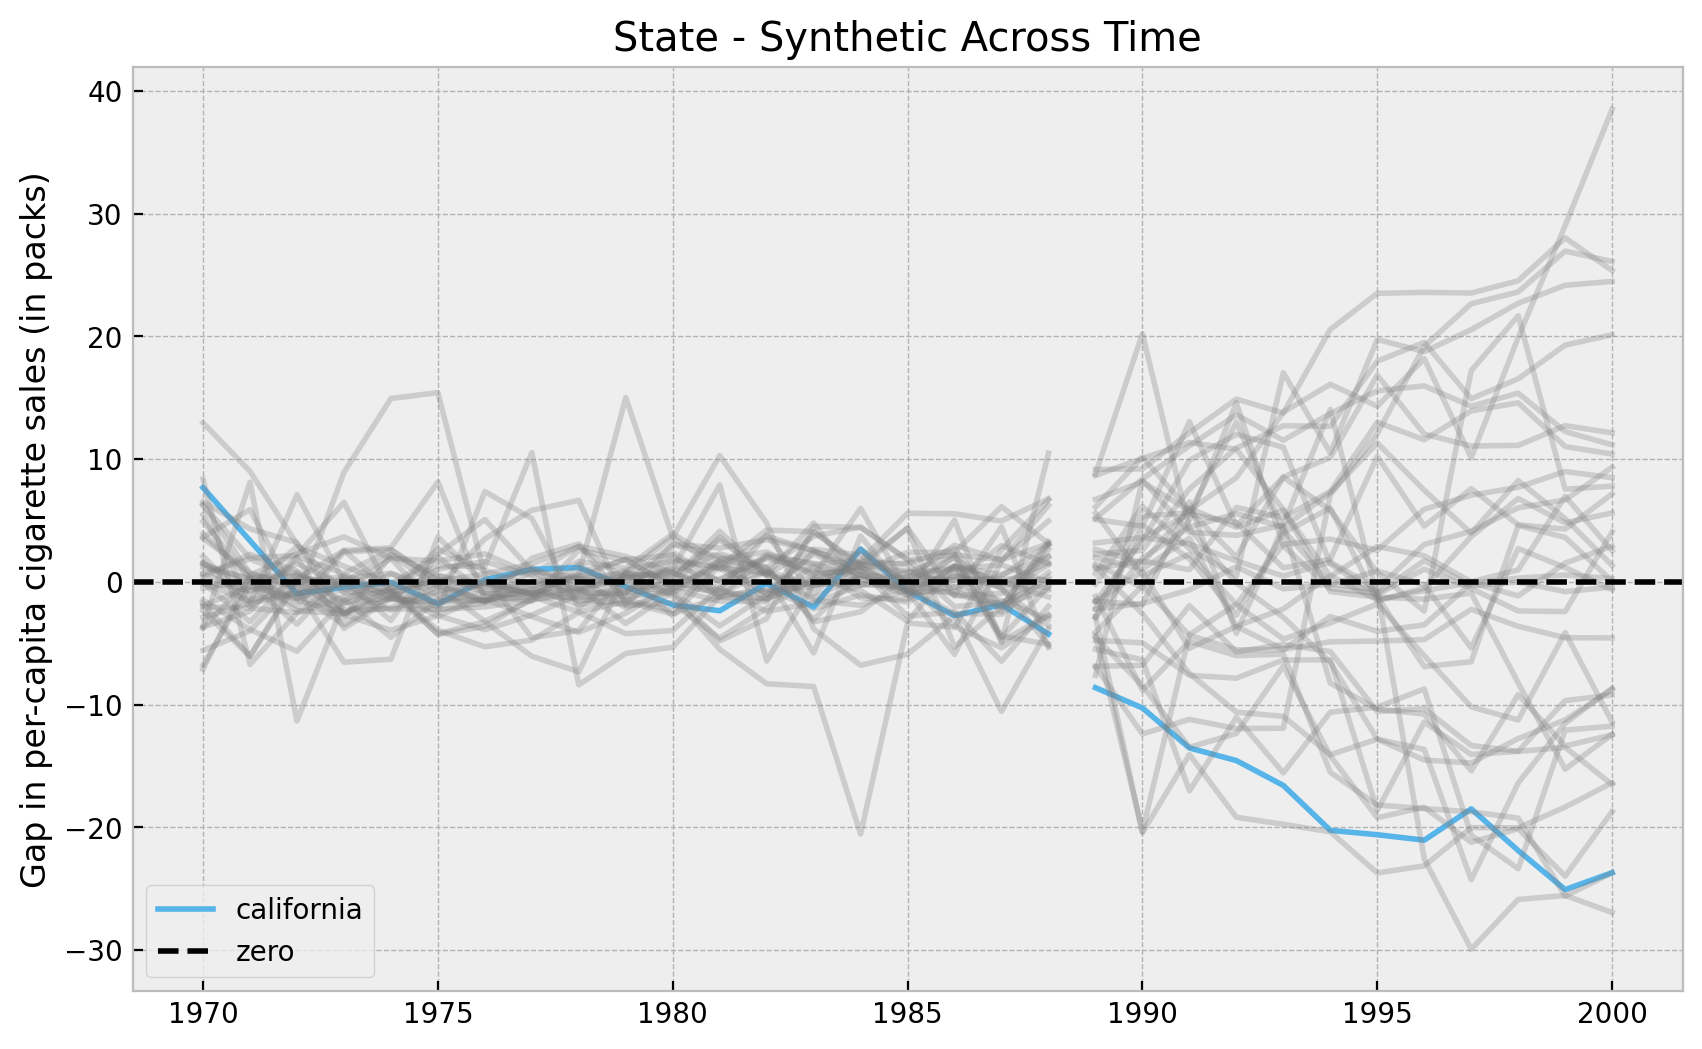

In [16]:
fig, ax = plt.subplots()

for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre < 10:
        color = "C6" if idx == 3 else "gray"
        alpha = 1 if idx == 3 else 0.3
        label = "california" if idx == 3 else None
        sns.lineplot(
            x=pre_years,
            y=error_pre.stack(samples=("chain", "draw")).mean(axis=1),
            color=color,
            alpha=alpha,
            ax=ax,
        )
        sns.lineplot(
            x=post_years,
            y=error_post.stack(samples=("chain", "draw")).mean(axis=1),
            color=color,
            alpha=alpha,
            label=label,
            ax=ax,
        )

ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="lower left")
ax.set(
    title="State - Synthetic Across Time",
    ylabel="Gap in per-capita cigarette sales (in packs)",
);

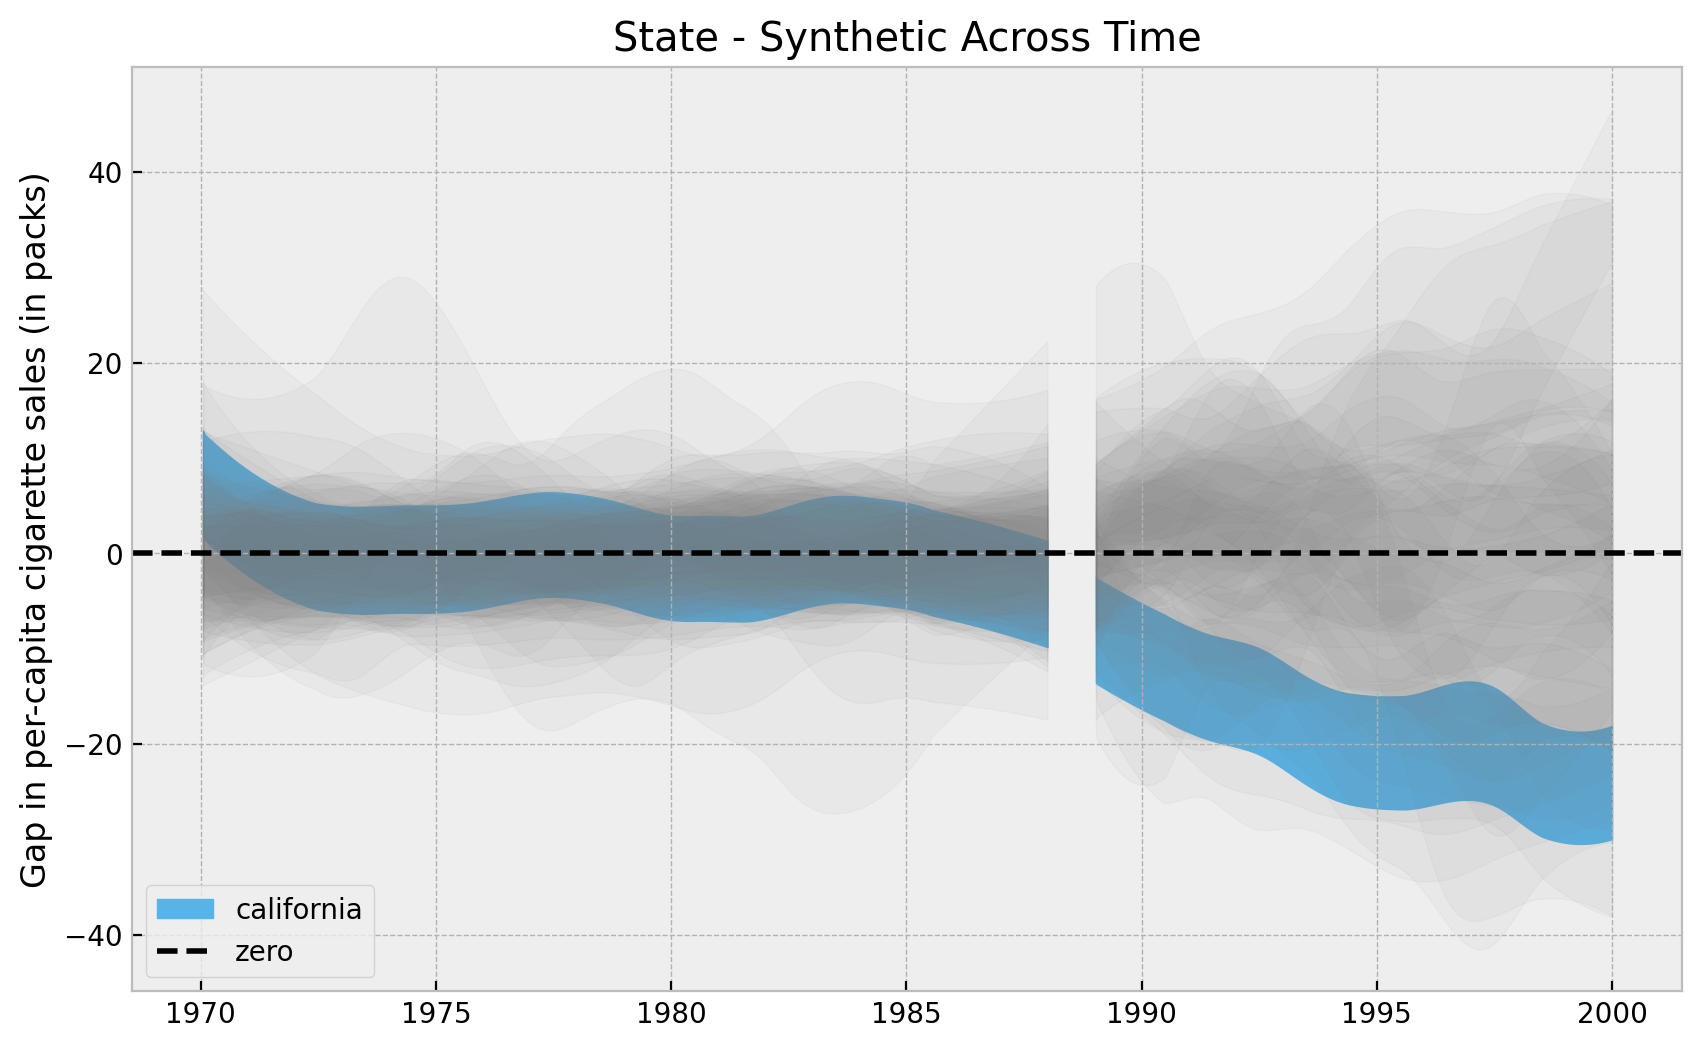

In [17]:
fig, ax = plt.subplots()

for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre < 10:
        color = "C6" if idx == 3 else "gray"
        alpha = 1 if idx == 3 else 0.05
        label = "california" if idx == 3 else None
        az.plot_hdi(
            x=pre_years,
            y=error_pre,
            smooth=True,
            color=color,
            fill_kwargs={"alpha": alpha},
            ax=ax,
        )
        az.plot_hdi(
            x=post_years,
            y=error_post,
            smooth=True,
            color=color,
            fill_kwargs={"alpha": alpha, "label": label},
            ax=ax,
        )

ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="lower left")
ax.set(
    title="State - Synthetic Across Time",
    ylabel="Gap in per-capita cigarette sales (in packs)",
);

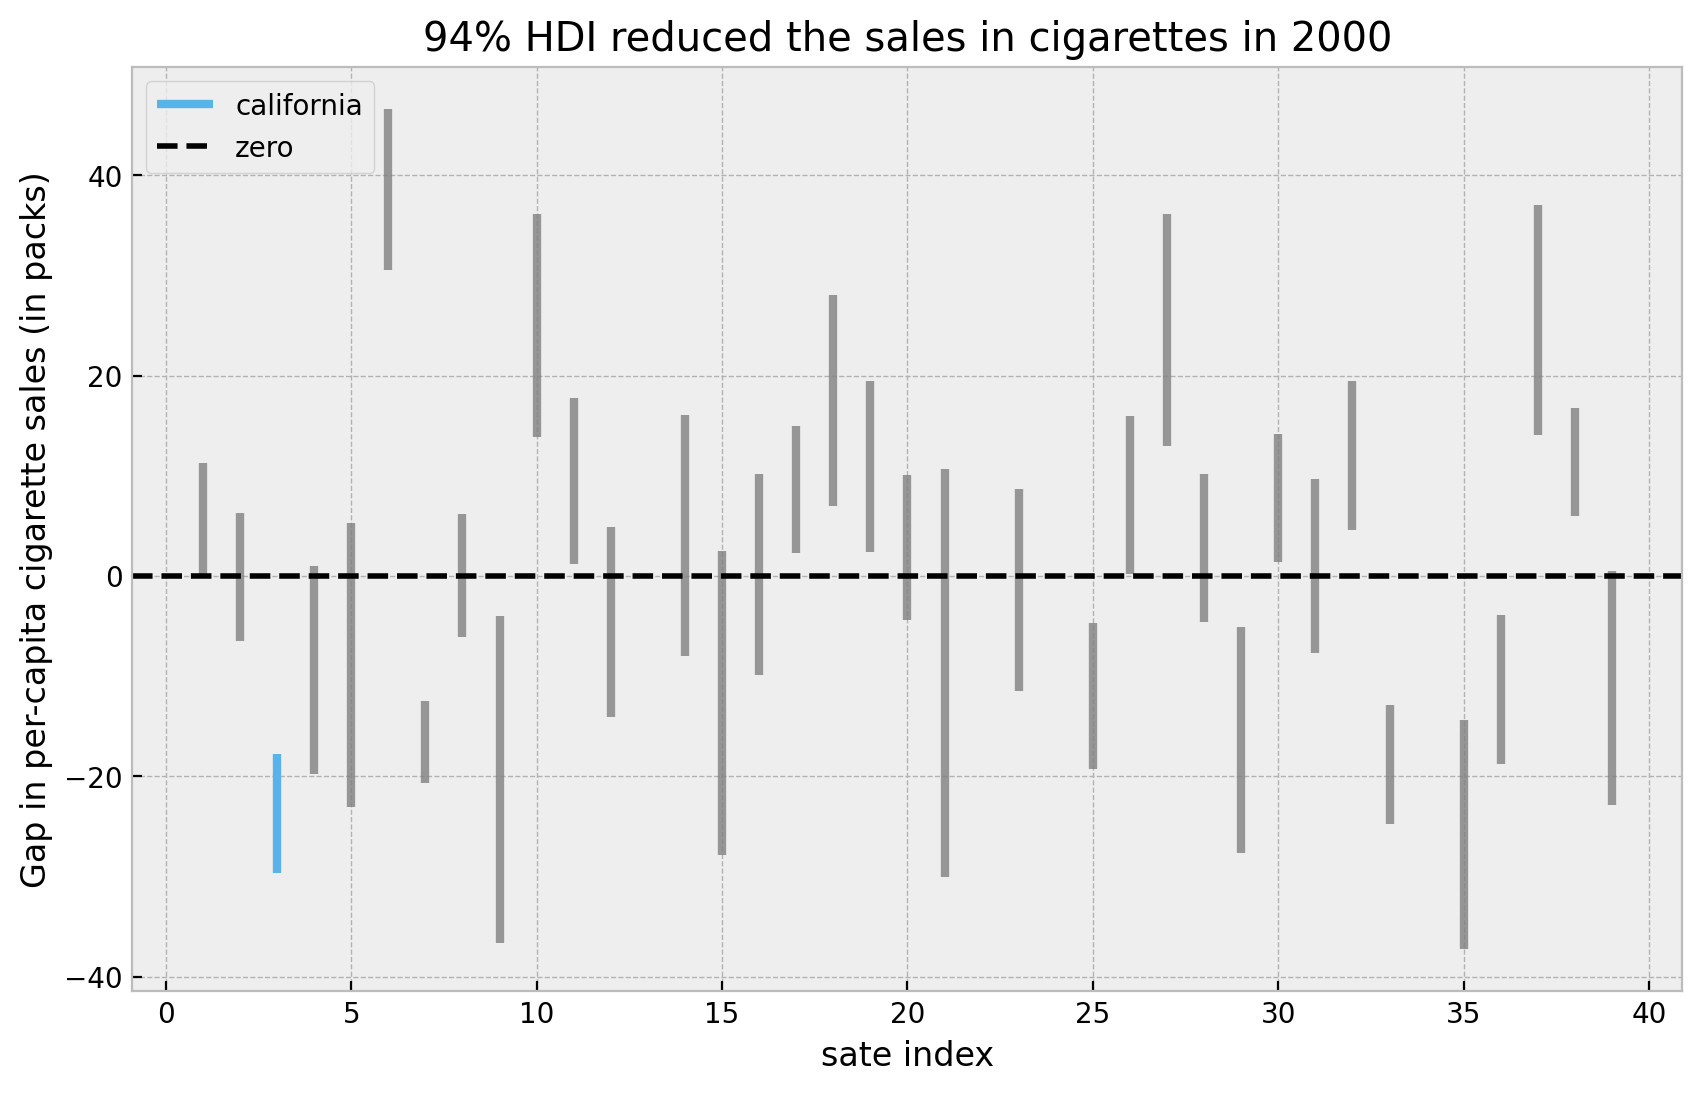

In [18]:
fig, ax = plt.subplots()

for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre < 10:
        color = "C6" if idx == 3 else "gray"
        alpha = 1 if idx == 3 else 0.8
        label = "california" if idx == 3 else None
        hdi = az.hdi(error_post[:, :, -1])["likelihood"].to_numpy()
        ax.vlines(
            x=idx,
            ymin=hdi[0],
            ymax=hdi[1],
            linestyle="solid",
            linewidth=3,
            color=color,
            alpha=alpha,
            label=label,
        )

ax.axhline(y=0.0, color="black", linestyle="--", label="zero")
ax.legend(loc="upper left")
ax.set(
    title="94% HDI reduced the sales in cigarettes in 2000",
    xlabel="sate index",
    ylabel="Gap in per-capita cigarette sales (in packs)",
);

In [19]:
for idx in df["state"].unique():
    error_pre, error_post = results[idx]
    sigma_pre = error_pre.stack(samples=("chain", "draw")).std(axis=1).min().item()
    if sigma_pre >= 10:
        print(idx)

13
22
24
34


In [20]:
cal_samples = np.array(
    [
        v[1].stack(samples=("chain", "draw")).T.to_numpy()
        for k, v in results.items()
        if k == 3
    ]
)

non_cal_samples = np.array(
    [
        v[1].stack(samples=("chain", "draw")).T.to_numpy()
        for k, v in results.items()
        if k not in [3, 13, 22, 24, 34]
    ]
)

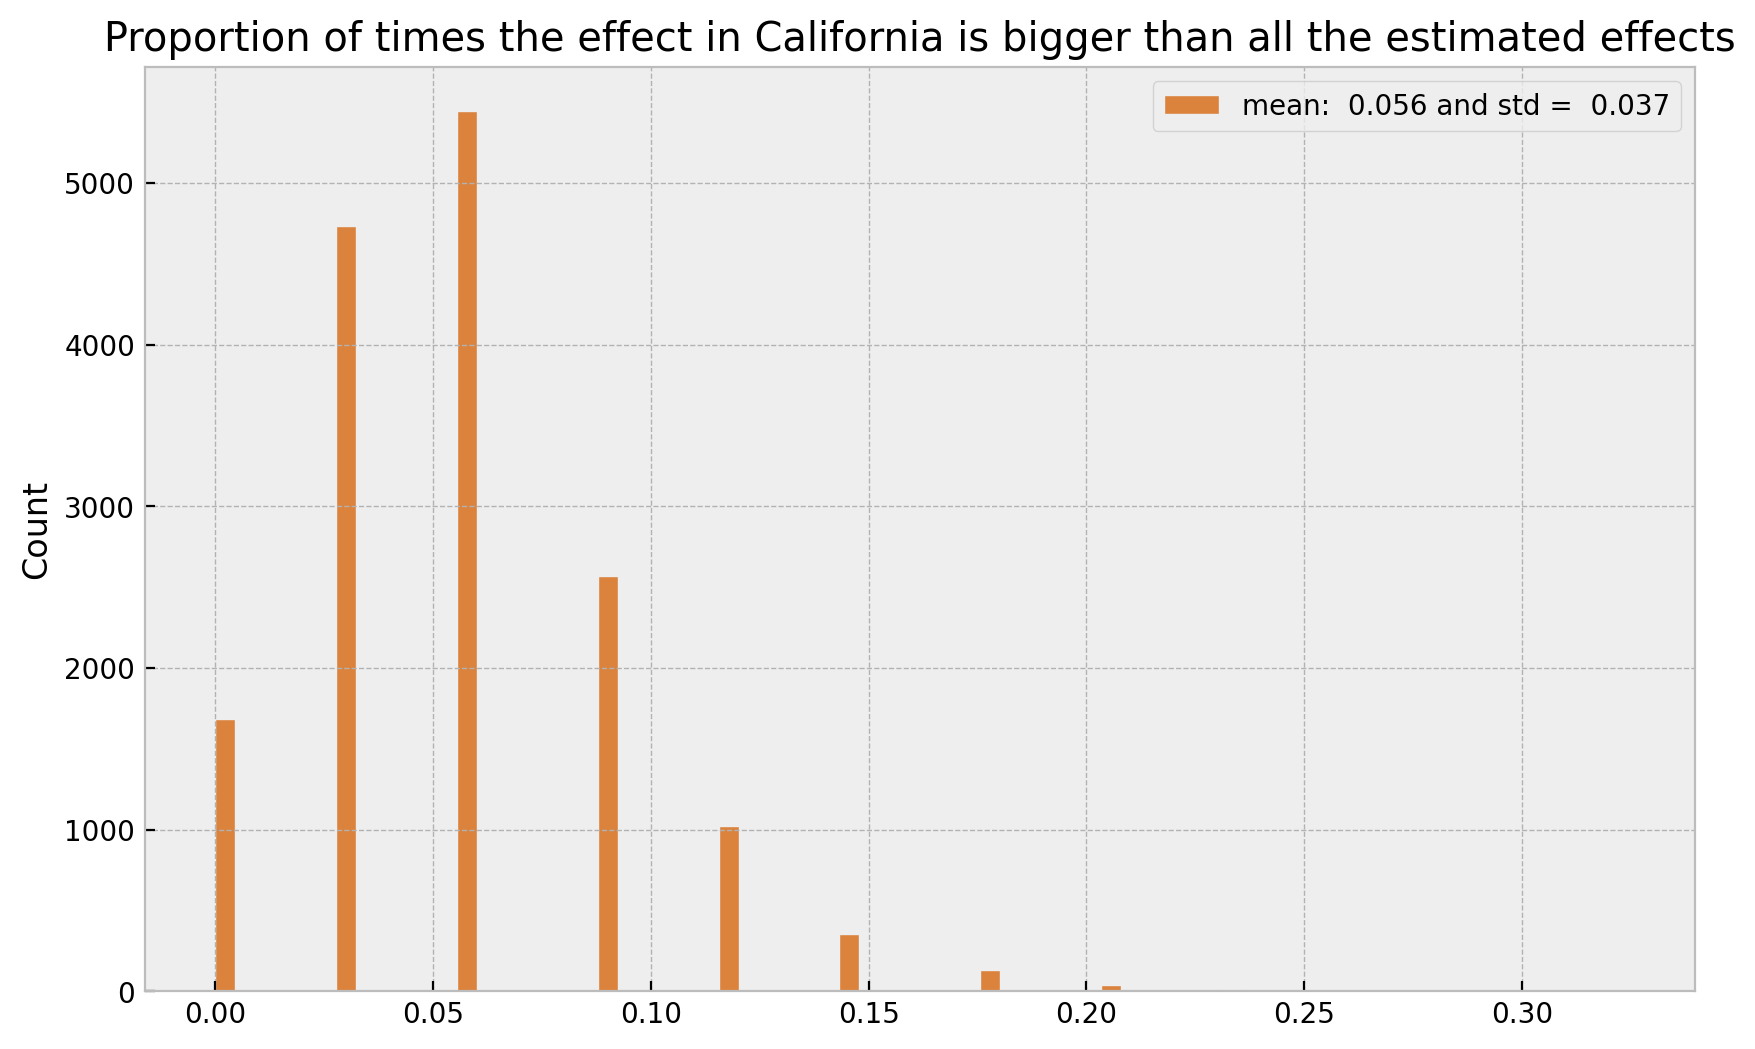

In [21]:
samples = (cal_samples[:, :, -1] > non_cal_samples[:, :, -1]).mean(axis=0)

fig, ax = plt.subplots()
sns.histplot(
    x=samples,
    color="C4",
    label=f"mean: {samples.mean(): .3f} and std = {samples.std(): .3f}",
    ax=ax,
)
ax.legend()
ax.set(
    title="Proportion of times the effect in California is bigger than all the estimated effects"
);

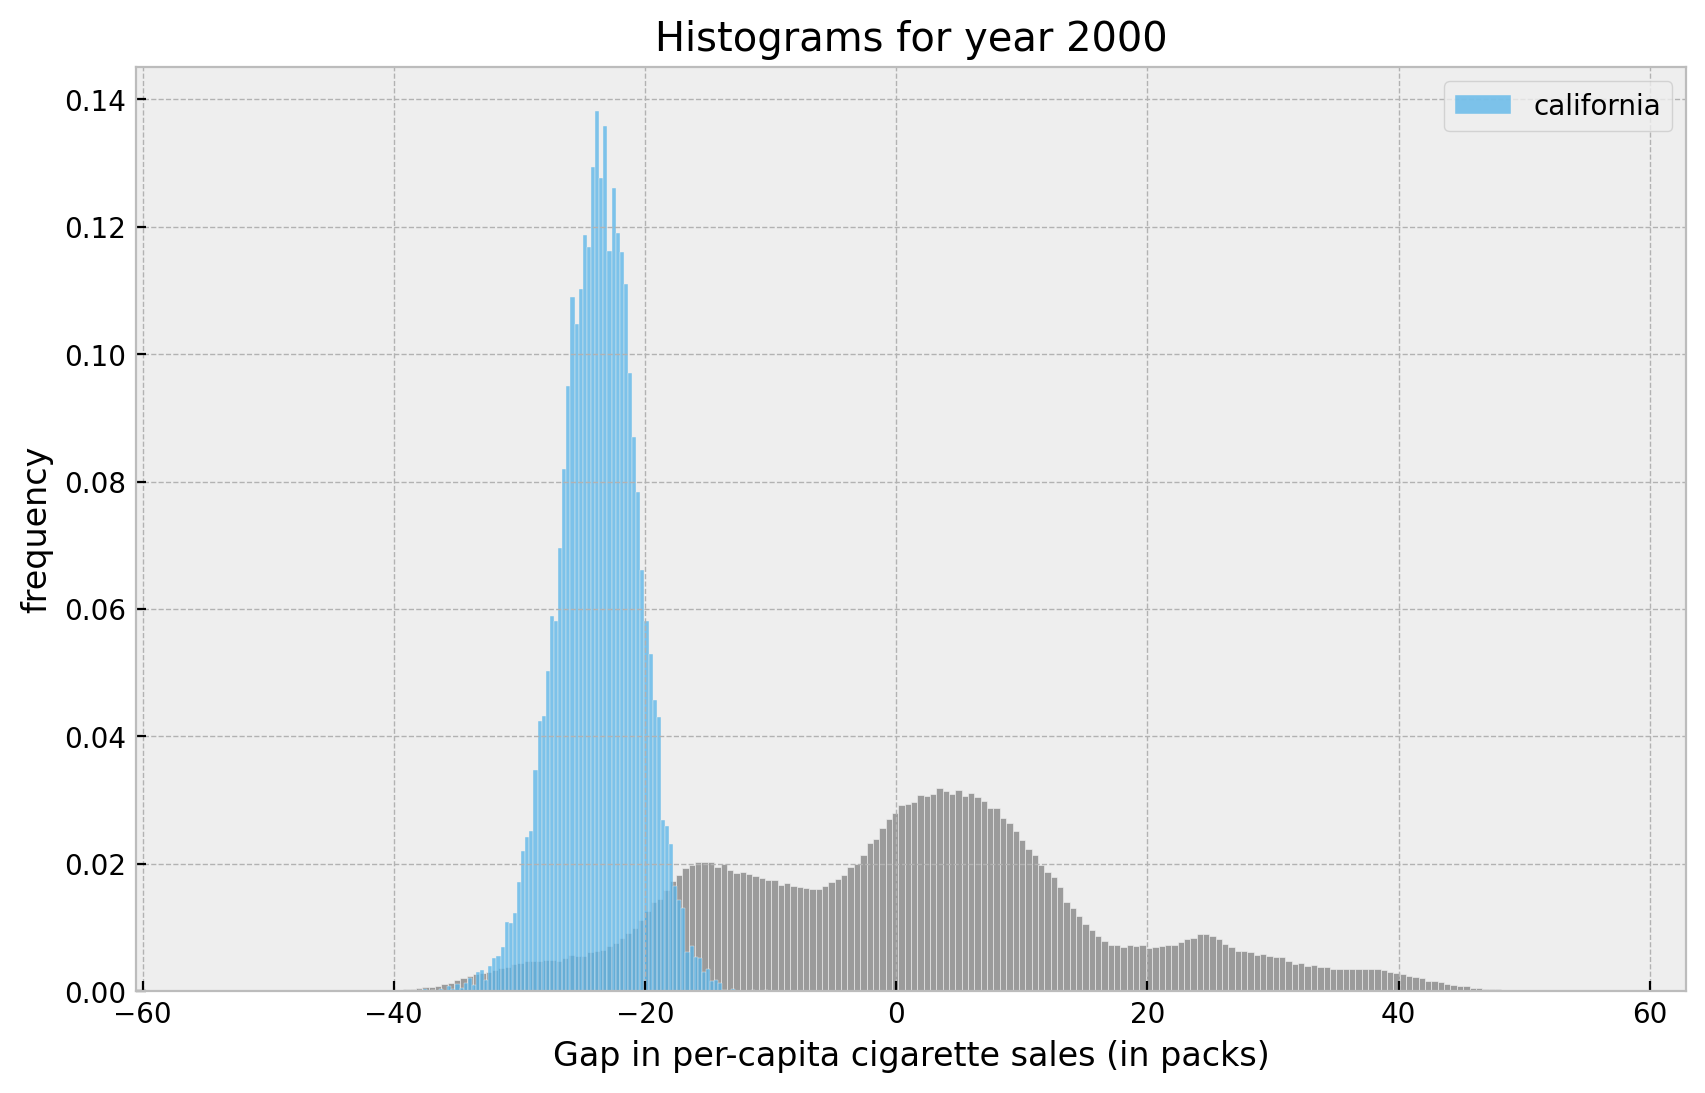

In [22]:
fig, ax = plt.subplots()
sns.histplot(x=non_cal_samples[:, :, -1].flatten(), color="gray", stat="density", ax=ax)
sns.histplot(
    x=cal_samples[:, :, -1].flatten(),
    color="C6",
    stat="density",
    label="california",
    ax=ax,
)
ax.legend(loc="upper right")
ax.set(
    title="Histograms for year 2000",
    xlabel="Gap in per-capita cigarette sales (in packs)",
    ylabel="frequency",
);